In [85]:
import json
import base64, hashlib, hmac, time
import requests
import pandas as pd
import numpy as np
import gdax
from requests.auth import AuthBase
from websocket import create_connection
from pymongo import MongoClient
from pprint import pprint
from sklearn.metrics import mean_squared_error
import math
import time
from datetime import datetime
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
import pause
import datetime
from PIL import Image
import requests
from io import BytesIO
import pyflux as pf

In [2]:
def df_maker(a_list):
    ''' takes GDAX API returned list and creates a pandas df '''
    df = pd.DataFrame(a_list)
    df.columns = ['time', 'low', 'high', 'open', 'close', 'volume']
    df.time = pd.to_datetime(df.time, unit='s')
    df.index = df.time
    df = df.drop(df.columns[0], axis=1)
    df = df.iloc[::-1]
    df.drop(df.tail(1).index,inplace=True)
    return df

In [3]:
def df_maker_future(a_list):
    ''' takes GDAX API returned list and creates a pandas df 
        this function only gets used when we fail to start the bot
        at the right time'''
    df = pd.DataFrame(a_list)
    df.columns = ['time', 'low', 'high', 'open', 'close', 'volume']
    df.time = pd.to_datetime(df.time, unit='s')
    df.index = df.time
    df = df.drop(df.columns[0], axis=1)
    df = df.iloc[::-1]
    #df.drop(df.tail(1).index,inplace=True)
    return df

In [ ]:
def vwap(df):
    ''' numpy version to calculate vwap '''
    v = df.volume.values
    h = df.high.values
    l = df.low.values
    c = df.close.values
    o = df.open.values

    df['vwap_numpy'] = np.cumsum(v*(o+h+l+c)/4) / np.cumsum(v)
    return df

In [ ]:
def relative_strength_index(df, n): # credits go to alex
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    df = df.reset_index()
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else: UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else: DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span = n, min_periods = n).mean())
    NegDI = pd.Series(DoI.ewm(span = n, min_periods = n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name = 'RSI_' + str(n))
    df = df.join(RSI)
    return df

# GDAX instantiation


For public_client pulls, I don't think you need to request API access to get those keys

In [4]:
public_client = gdax.PublicClient()

In [5]:
auth_client = gdax.AuthenticatedClient(FOUR SECRET KEYS)

In [8]:
public_client.get_product_trades(product_id='LTC-USD') 

[{'price': '116.86000000',
  'side': 'sell',
  'size': '5.76990000',
  'time': '2018-04-04T19:38:22.786Z',
  'trade_id': 28481819},
 {'price': '116.86000000',
  'side': 'sell',
  'size': '5.05060000',
  'time': '2018-04-04T19:38:11.989Z',
  'trade_id': 28481818},
 {'price': '116.85000000',
  'side': 'buy',
  'size': '9.98542734',
  'time': '2018-04-04T19:38:11.272Z',
  'trade_id': 28481817},
 {'price': '116.85000000',
  'side': 'buy',
  'size': '0.01457266',
  'time': '2018-04-04T19:38:11.272Z',
  'trade_id': 28481816},
 {'price': '116.85000000',
  'side': 'buy',
  'size': '0.10800000',
  'time': '2018-04-04T19:38:00.041Z',
  'trade_id': 28481815},
 {'price': '116.86000000',
  'side': 'sell',
  'size': '1.73320000',
  'time': '2018-04-04T19:37:47.29Z',
  'trade_id': 28481814},
 {'price': '116.86000000',
  'side': 'sell',
  'size': '1.41150000',
  'time': '2018-04-04T19:37:34.956Z',
  'trade_id': 28481813},
 {'price': '116.85000000',
  'side': 'buy',
  'size': '5.00000000',
  'time': '2

In [9]:
# This pulls 300 hours worth of data from GDAX, by the hour
public_client.get_product_historic_rates('LTC-USD', granularity = 3600)

[[1522870200, 116.73, 117.73, 117.24, 117.73, 2181.6347098200004],
 [1522869300, 116.55, 117.3, 117.3, 117.25, 3737.8751669400003],
 [1522868400, 116.51, 117.4, 116.8, 117.3, 2765.76685233],
 [1522867500, 116.21, 116.8, 116.46, 116.8, 2406.4781112500004],
 [1522866600, 115.5, 116.87, 116.47, 116.6, 6984.889042589998],
 [1522865700, 116.1, 117.18, 116.25, 116.47, 5317.99429016],
 [1522864800, 116.26, 118.2, 118.12, 116.26, 7290.693360780001],
 [1522863900, 117.72, 118.49, 118.29, 118.2, 1790.4119648700002],
 [1522863000, 117.55, 118.42, 117.99, 118.29, 4633.502001480001],
 [1522862100, 117.75, 118.98, 118.71, 118, 3929.66816942],
 [1522861200, 118.2, 119, 118.57, 118.71, 4465.71029643],
 [1522860300, 118.01, 118.79, 118.72, 118.57, 2931.9060087100006],
 [1522859400, 117.5, 118.72, 117.92, 118.72, 3510.1587680800008],
 [1522858500, 117.32, 118.25, 117.89, 117.7, 4277.42665605],
 [1522857600, 116.58, 118.08, 116.77, 117.89, 4960.59739178],
 [1522856700, 116, 118.3, 118.2, 116.77, 11544.36

In [45]:
hour_data = df_maker(public_client.get_product_historic_rates('LTC-USD', granularity = 3600))

In [13]:
hour_data

,low,high,open,close,volume
time,,,,,
2018-03-23 08:00:00,158.19,160.64,158.19,159.90,7102.913438
2018-03-23 09:00:00,159.10,160.91,159.89,159.10,6520.455280
2018-03-23 10:00:00,158.60,160.39,159.10,160.18,3205.282277
2018-03-23 11:00:00,159.34,161.38,160.17,161.27,5066.468525
2018-03-23 12:00:00,157.15,161.40,161.27,157.69,8729.632060
2018-03-23 13:00:00,157.06,158.09,157.66,158.09,7775.657435
2018-03-23 14:00:00,158.03,161.76,158.09,161.39,14837.713093
2018-03-23 15:00:00,161.39,163.70,161.39,162.98,17499.935792
2018-03-23 16:00:00,161.84,163.70,162.99,162.84,9835.648500


# Time Series

In [6]:
def var_forecast(data):
    ''' VAR model magic for our forecasting '''
    model = VAR(data)
    results = model.fit(1)
    results.summary()
    lag_order = results.k_ar
    return results.forecast(data.values[-lag_order:], 1)

In [89]:
model = VAR(hour_data)
model.select_order(5) # This shows us the lowest AIC for lag selection

                 VAR Order Selection                 
           aic          bic          fpe         hqic
-----------------------------------------------------
0        23.93        23.99    2.470e+10        23.96
1       11.38*       11.76*   8.763e+04*       11.53*
2        11.41        12.10    9.016e+04        11.69
3        11.46        12.46    9.512e+04        11.86
4        11.49        12.80    9.769e+04        12.02
5        11.56        13.19    1.050e+05        12.21
* Minimum



{'aic': 1, 'bic': 1, 'fpe': 1, 'hqic': 1}

In [51]:
var_forecast(df_maker(public_client.get_product_historic_rates('LTC-USD', granularity = 3600)))

array([[   115.5922477 ,    118.3401222 ,    116.74822343,    116.94423737,
         20717.01884122]])

VAR(1)                                                                                                    
======================================================= ==================================================
Dependent Variable: Differenced low,Differenced high,Di Method: OLS                                       
Start Date: 2018-03-23 10:00:00                         Log Likelihood: -4004.1566                        
End Date: 2018-04-04 19:00:00                           AIC: 8098.3131                                    
Number of observations: 297                             BIC: 8264.5311                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Differenced low Constant                 -0.0858    0.0779     -1.101   0.2709   (-0.2384 | 0.0669)       
Differenced low AR(1)                

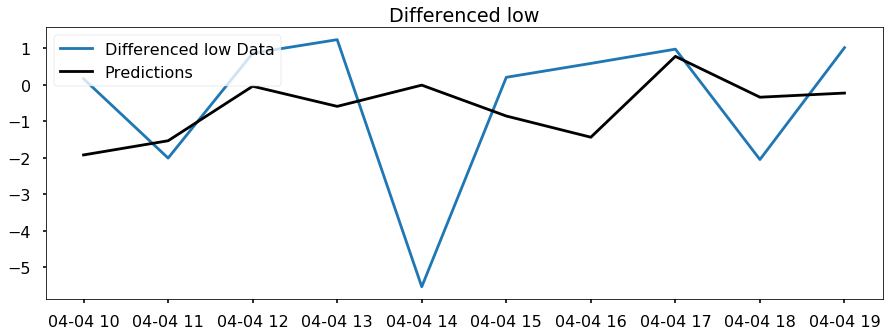

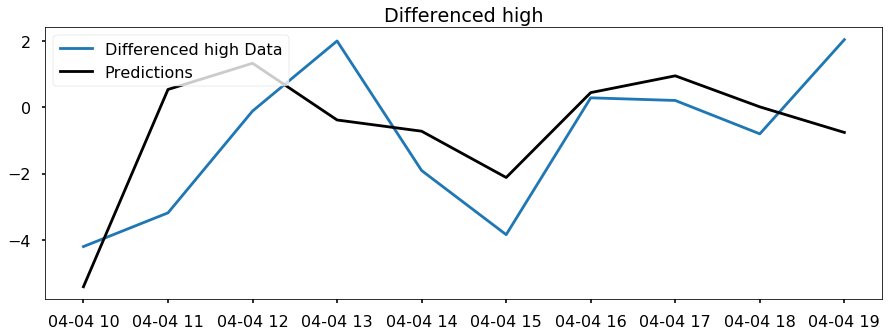

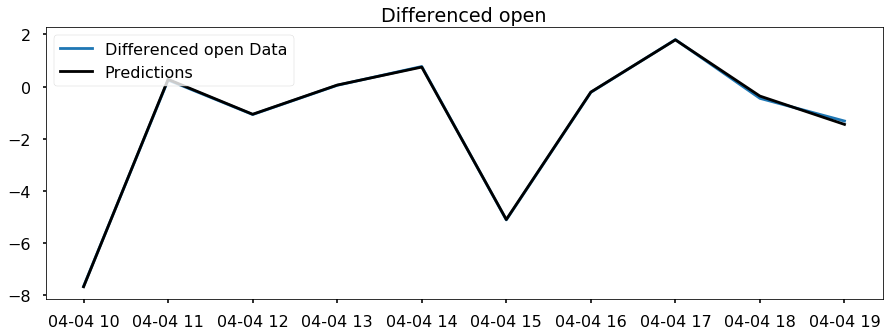

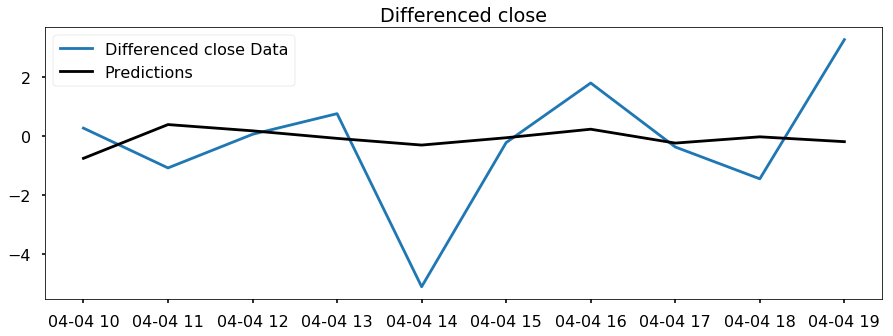

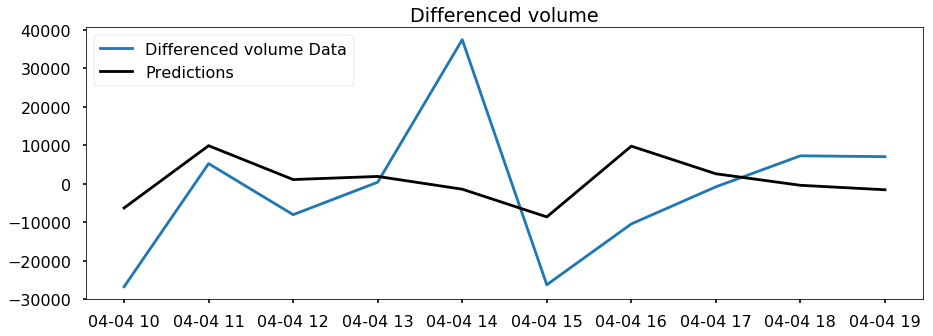

In [88]:
# PyFlux kind of outdated though

pymodel = pf.VAR(data=df_maker(public_client.get_product_historic_rates('LTC-USD', granularity = 3600)), lags=1, integ=1)
x = pymodel.fit()
x.summary()
pymodel.plot_predict_is(h=10, fit_once = 1, figsize=((15,5)))

# PyFlux tends to forecast wider candles, which isn't that great

# Bot Stuff

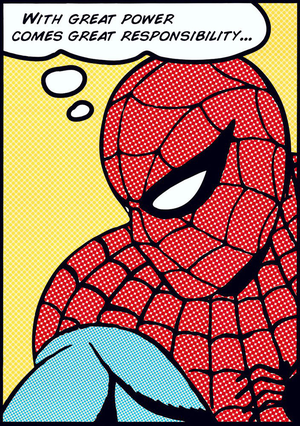

In [86]:
basewidth = 300
img = img = Image.open(BytesIO(response.content))
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img

GENERAL RULES

bull market rules - vwap increasing, RSI under 30
bear market rules - vwap decreasing, RSI over 70

check balance - 

bank = auth_client.get_accounts()

bank[0].get('available') for coins in bag

bank[0].get('hold') for coins in order

bank[3].get('available') for usd

bank[3].get('hold') for usd in order


if float(bank[0].get('available')) > 0: # meaning we have coins not in an order
    sell
if float(bank[3].get('available')) > 2: # meaning we have usd not in an order, 2 is in case we have pennies leftover
    buy
if float(bank[0].get('hold')) > 0 and time is still within our prediction window: 
    wait?


generate hourly predictions
generate 15 min predictions
set buy 
if buy unfulfilled, cancel after X mins - this would mean that the price didn't hit the low
if buy filled, move onto sell, otherwise regenerate predictions

set sell
if sell unfulfilled, cancel after X mins - this would mean the price didn't hit the high
if cancelled, what do I do? 
    * option 1: set sell for bought price and hope - most realistic
    * option 2: sell at a loss??? market sell if price drops below 1% of bought in price?

if sell filled, move back into buy

check if balance is less than what we started with, if less than 3% then stop

In [1]:
# This will run the bot for an hour before stopping

# HOURLY BEAR PROTOCOL!!!

# GDAX's hourly buckets refresh every XX:02, so we're gonna pause until that time happens
#pause.until(datetime.datetime.now().replace(microsecond=0,second=0,minute=0)+datetime.timedelta(hours=1, minutes = 2))
while True:
    data = df_maker(public_client.get_product_historic_rates('LTC-USD', granularity = 3600))
    guess_hour = var_forecast(data)
    bank = auth_client.get_accounts()
    balance_str = bank[3].get('available')
    balance = math.floor(float(balance_str)) - 1 # We're going to floor this float so we don't hit insufficient funds in making our orders
    if float(bank[0].get('hold')) != 0: # this part says "hey, if we have coins up for sale, then chill out"
        False
        
    #Sentiment not needed for bear market
    #arima_mod_o = sm.tsa.ARIMA(df.open, order=(1,1,1), missing = 'drop').fit()
    #arima_mod_o.forecast(steps=1, exog = df.sentiment, alpha=0.05)
    #arima_mod_h = sm.tsa.ARIMA(df.high, order=(1,1,1), missing = 'drop').fit()
    #arima_mod_h.forecast(steps=1, exog = df.sentiment, alpha=0.05)
    #arima_mod_l = sm.tsa.ARIMA(df.low, order=(1,1,1), missing = 'drop').fit()
    #arima_mod_l.forecast(steps=1, exog = df.sentiment, alpha=0.05)
    #arima_mod_c = sm.tsa.ARIMA(df.close, order=(1,1,1), missing = 'drop').fit()
    #arima_mod_c.forecast(steps=1, exog = df.sentiment, alpha=0.05)
    sentiment_multiplier = 0.95
    #sentiment_multiplier = (guess_hour[0][0] * arima_mod_o.forecast(steps=1, exog = df.sentiment, alpha=0.05)) / 2
    bull = 0
    now = datetime.now()
    if relative_strength_index(data, 14).tail(1).RSI_14 < 0.7: # RSI rules
        bull = 1
    if bull == 1:
        auth_client.buy(price='%.2f' % (guess_hour[0][0]), size='%.8f' % (balance / guess_hour[0][0]), product_id='LTC-USD')
    else:
        auth_client.buy(price='%.2f' % (guess_hour[0][0] - 1), size='%.8f' % (balance / guess_hour[0][0]), product_id='LTC-USD')
        #auth_client.buy(price='%.2f' % (sentiment_multiplier), size='%.8f' % (balance / sentiment_multiplier), product_id='LTC-USD')

    hour_bought = 0
    
    while True:
        time.sleep(30)
        if float(bank[3].get('hold')) == 0:
            #print("BOUGHT! $", guess_hour[0][0])
            auth_client.sell(price='%.2f' % (guess_hour[0][3]), # This is our predicted closing price
                    size=auth_client.get_accounts()[0].get('available'), 
                    product_id='LTC-USD')
            hour_bought = 1
            if float(bank[0].get('hold')) == 0 and hour_bought == 1: #if we bought and sold, bot chills out
                pause.until(datetime.datetime.now().replace(microsecond=0,second=0,minute=0)+datetime.timedelta(hours=1))
                False
                
               # wait until next hour, then re-run script
            #False
        #count += 1
        
        # here, if we're still holding coins as the hour ends, we'll just leave them up for sale and PRAY
        if float(bank[0].get('hold')) != 0:
            if datetime.datetime.now() == datetime.datetime.now().replace(microsecond=0,second=0,minute=0)+datetime.timedelta(hours=1):
                auth_client.cancel_all(product = 'LTC-USD')
                False

NameError: name 'df_maker' is not defined